<a href="https://colab.research.google.com/github/matsunagalab/ColabBTR/blob/main/BTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data

In [ ]:
!pip install --upgrade gdown

!gdown 1fv1ROIuE-1UGbQ6pxsWzSO4CTQwneUnw
!gdown 1fqkYqCijVlqIIhnxNEmQ2ucDcmf3vOHx
!gdown 1fvMRgqC7ltyQ0Q8PM2fRO9tZ-WJ7pi_E
!gdown 1g-9byW9F8pmcyz2glxTOaSapGZZcr-TA

Downloading...
From: https://drive.google.com/uc?id=1fv1ROIuE-1UGbQ6pxsWzSO4CTQwneUnw
To: /content/images.npy
100% 4.15M/4.15M [00:00<00:00, 25.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fqkYqCijVlqIIhnxNEmQ2ucDcmf3vOHx
To: /content/tip.npy
100% 1.20k/1.20k [00:00<00:00, 5.73MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fvMRgqC7ltyQ0Q8PM2fRO9tZ-WJ7pi_E
To: /content/surfs.npy
100% 4.15M/4.15M [00:00<00:00, 25.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1g-9byW9F8pmcyz2glxTOaSapGZZcr-TA
To: /content/images_clean.npy
100% 4.15M/4.15M [00:00<00:00, 25.1MB/s]


In [ ]:
import numpy as np
images = np.load('/content/images.npy')
images_clean = np.load('/content/images_clean.npy')
tip = np.load('/content/tip.npy')
surfaces = np.load('/content/surfs.npy')

surface = surfaces[0, :, :]
image = images_clean[0, :, :]

# Define functions

In [ ]:
import torch


def compute_xc_yc(tip):
    tip_xsiz, tip_ysiz = tip.size()
    xc = round((tip_xsiz - 1) / 2)
    yc = round((tip_ysiz - 1) / 2)
    return xc, yc


def idilation(surface, tip):
    # Move tensors to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    surface = surface.to(device)
    tip = tip.to(device)

    xc, yc = compute_xc_yc(tip)
    surf_xsiz, surf_ysiz = surface.size()
    tip_xsiz, tip_ysiz = tip.size()

    # Initialize result tensor on GPU
    r = torch.full_like(surface, -float('inf'))

    # Replace nested loops with PyTorch operations
    # Note: The following is a simplified version. Depending on the specific requirements of the dilation operation,
    # you may need to adjust the logic to achieve the correct result.
    for px in range(-xc, tip_xsiz - xc):
        for py in range(-yc, tip_ysiz - yc):
            temp = torch.roll(surface, shifts=(-px, -py), dims=(0, 1))
            temp = temp + tip[xc + px, yc + py]
            r = torch.maximum(r, temp)

    return r


def ierosion(image, tip):
    # Move tensors to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = image.to(device)
    tip = tip.to(device)

    xc, yc = compute_xc_yc(tip)
    im_xsiz, im_ysiz = image.size()
    tip_xsiz, tip_ysiz = tip.size()

    # Initialize result tensor on GPU
    r = torch.full_like(image, float('inf'))

    # Replace nested loops with PyTorch operations
    # Note: The following is a simplified version. Depending on the specific requirements of the erosion operation,
    # you may need to adjust the logic to achieve the correct result.
    for px in range(-xc, tip_xsiz - xc):
        for py in range(-yc, tip_ysiz - yc):
            temp = torch.roll(image, shifts=(px, py), dims=(0, 1))
            temp = temp - tip[xc + px, yc + py]
            r = torch.minimum(r, temp)

    return r


def translate_tip_mean(P, cutoff=10**(-8)):
    # Ensure P is on GPU
    P = P.to('cuda' if torch.cuda.is_available() else 'cpu')

    tip_xsiz, tip_ysiz = P.size()
    xc, yc = compute_xc_yc(P)

    #p_max = torch.min(P)
    #P = P - p_max

    p_min = torch.min(P)
    weight = P - p_min
    weight = weight

    id = weight < cutoff
    weight[id] = 0.0

    if torch.all(weight < 10**(-10)):
        #print('called')
        weight.fill_(1.0)

    ix = torch.ones(tip_xsiz, tip_ysiz, dtype=P.dtype, device=P.device)
    iy = torch.ones(tip_xsiz, tip_ysiz, dtype=P.dtype, device=P.device)
    ix = torch.cumsum(ix, dim=0) - 1.0
    iy = torch.cumsum(iy, dim=1) - 1.0
    com_x = torch.sum(ix * weight / torch.sum(weight))
    com_y = torch.sum(iy * weight / torch.sum(weight))
    id_x = round(com_x.item())
    id_y = round(com_y.item())

    pxmin = max(- xc, - id_x)
    pymin = max(- yc, - id_y)
    pxmax = min(tip_xsiz - xc, tip_xsiz - id_x)
    pymax = min(tip_ysiz - yc, tip_ysiz - id_y)

    #print(id_x, id_y)
    P_new = torch.full_like(P, p_min.item())
    P_new[(xc + pxmin):(xc + pxmax), (yc + pymin):(yc + pymax)] = P[(id_x + pxmin):(id_x + pxmax), (id_y + pymin):(id_y + pymax)]

    return P_new


# Check dilation

In [ ]:
import torch
import torch.optim as optim
import numpy as np

# Data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
surface_tensor = torch.tensor(surface, dtype=torch.float32)
image_tensor = torch.tensor(image, dtype=torch.float32)
surface_tensor = surface_tensor.to(device)
image_tensor = image_tensor.to(device)

# Initialization
tip_tensor = torch.zeros(tip.shape, dtype=torch.float32, requires_grad=True)

# Optimization settings
learning_rate = 0.1
optimizer = optim.Adam([tip_tensor], lr=learning_rate)
num_iterations = 300

# Optimization loop
for iteration in range(num_iterations):
    optimizer.zero_grad()  # Clear gradients from the previous iteration

    # Perform dilation
    image2_tensor = idilation(surface_tensor, tip_tensor)

    # Calculate MSE loss
    loss = torch.mean((image2_tensor - image_tensor) ** 2)

    # Backpropagation
    loss.backward()

    # Update tip
    optimizer.step()

    # Optional: print loss every few iterations
    if iteration % 100 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item()}")

# Final optimized tip
tip_estimate = tip_tensor.detach().numpy()


Iteration 0, Loss: 430.6541748046875


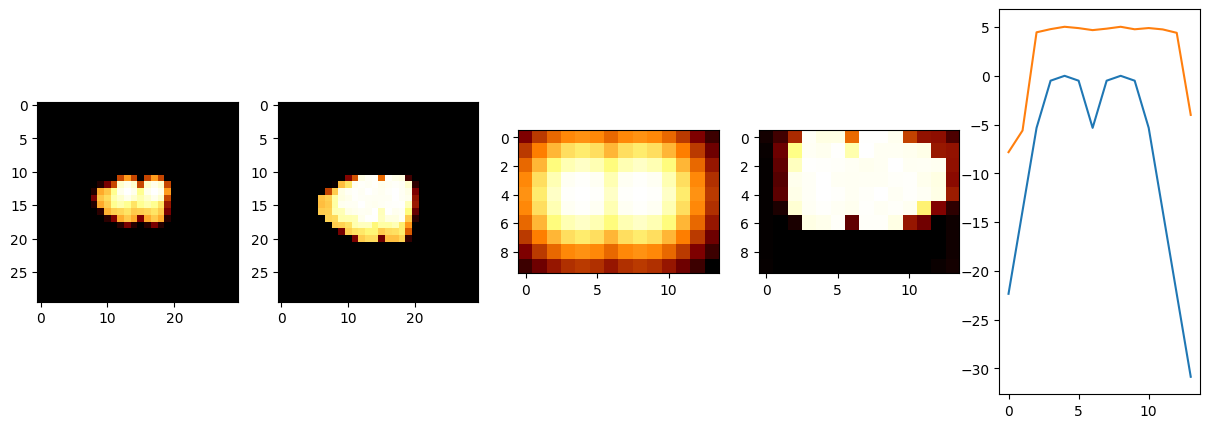

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 5, 1)
import matplotlib.pyplot as plt
plt.imshow(image_tensor.cpu(), cmap='afmhot')

plt.subplot(1, 5, 2)
plt.imshow(idilation(surface_tensor, tip_tensor).cpu().detach().numpy(), cmap='afmhot')

plt.subplot(1, 5, 3)
plt.imshow(tip, cmap='afmhot')

plt.subplot(1, 5, 4)
plt.imshow(tip_estimate, cmap='afmhot')

plt.subplot(1, 5, 5)
plt.plot(tip[4, :])
plt.plot(tip_estimate[4, :])

# Check erosion

In [ ]:
import torch
import torch.optim as optim
import numpy as np

# Data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
surface_tensor = torch.tensor(surface, dtype=torch.float32)
image_tensor = torch.tensor(image, dtype=torch.float32)
surface_tensor = surface_tensor.to(device)
image_tensor = image_tensor.to(device)

# Initialization
tip_tensor = torch.zeros(tip.shape, dtype=torch.float32, requires_grad=True)

# Optimization settings
learning_rate = 0.1
optimizer = optim.Adam([tip_tensor], lr=learning_rate)
num_iterations = 300

# Optimization loop
for iteration in range(num_iterations):
    optimizer.zero_grad()  # Clear gradients from the previous iteration

    # Perform dilation
    surface2_tensor = ierosion(image_tensor, tip_tensor)

    # Calculate MSE loss
    loss = torch.mean((surface2_tensor - surface_tensor) ** 2)

    # Backpropagation
    loss.backward()

    # Update tip
    optimizer.step()

    # Optional: print loss every few iterations
    if iteration % 100 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item()}")

# Final optimized tip
tip_estimate = tip_tensor.detach().numpy()


Iteration 0, Loss: 1.2789931297302246
Iteration 100, Loss: 0.14948897063732147
Iteration 200, Loss: 0.08355692028999329


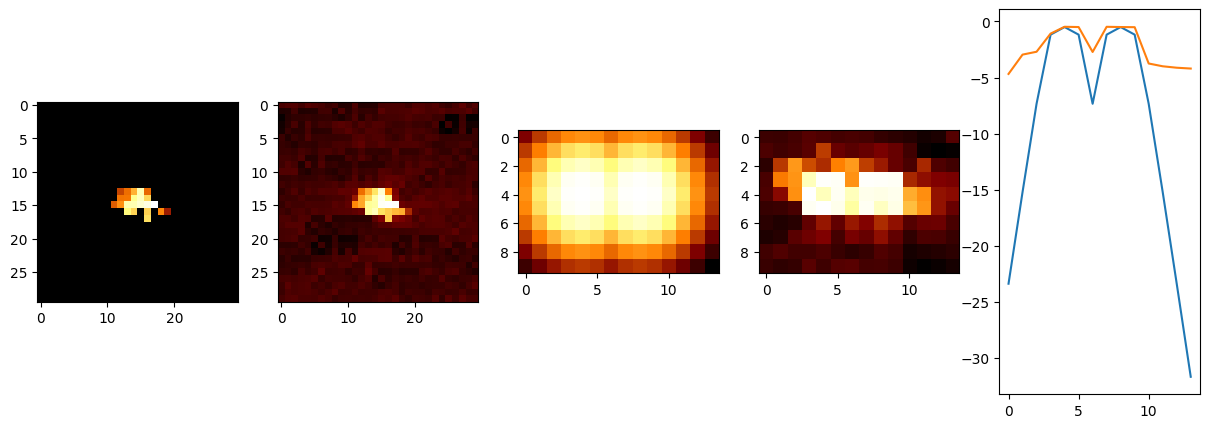

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 5, 1)
import matplotlib.pyplot as plt
plt.imshow(surface_tensor.cpu(), cmap='afmhot')

plt.subplot(1, 5, 2)
plt.imshow(ierosion(image_tensor, tip_tensor).cpu().detach().numpy(), cmap='afmhot')

plt.subplot(1, 5, 3)
plt.imshow(tip, cmap='afmhot')

plt.subplot(1, 5, 4)
plt.imshow(tip_estimate, cmap='afmhot')

plt.subplot(1, 5, 5)
plt.plot(tip[3, :])
plt.plot(tip_estimate[3, :])

# Check opening

In [ ]:
import torch
import torch.optim as optim
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor = torch.tensor(images[0, :, :], dtype=torch.float32)
image_tensor = image_tensor.to(device)

# Initialize tip with random values
tip_size = tip.shape
tip_tensor = torch.zeros(tip_size, dtype=torch.float64, requires_grad=True, device=device)

# Optimization settings
optimizer = optim.Adam([tip_tensor], lr=1.0)
num_iterations = 2000

# Optimization loop
for iteration in range(num_iterations):
    optimizer.zero_grad()  # Clear gradients from the previous iteration

    # Perform dilation
    image_reconstructed = idilation(ierosion(image_tensor, tip_tensor), tip_tensor)
    #print(torch.max(image_reconstructed))

    # Calculate MSE loss
    loss = torch.mean((image_reconstructed - image_tensor)**2)

    # Backpropagation
    loss.backward()
    #print(tip_tensor.grad)

    # Update tip
    optimizer.step()

    with torch.no_grad():
        tip_tensor.data = torch.clamp(tip_tensor, max=0.0)
        tip_tensor.data = translate_tip_mean(tip_tensor)

    # Optional: print loss every few iterations
    if iteration % 100 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item()}")

# Final optimized tip
tip_estimate = tip_tensor.detach().to('cpu').numpy()

Iteration 0, Loss: 6.582793712615967
Iteration 100, Loss: 1.0190784931182861
Iteration 200, Loss: 0.16813528537750244
Iteration 300, Loss: 0.043503545224666595
Iteration 400, Loss: 0.056540898978710175
Iteration 500, Loss: 0.0519430972635746
Iteration 600, Loss: 0.06316188722848892
Iteration 700, Loss: 0.057861506938934326
Iteration 800, Loss: 0.06803872436285019
Iteration 900, Loss: 0.06905794143676758
Iteration 1000, Loss: 0.06740820407867432
Iteration 1100, Loss: 0.0598723404109478
Iteration 1200, Loss: 0.06861723959445953
Iteration 1300, Loss: 0.07698190957307816
Iteration 1400, Loss: 0.06875220686197281
Iteration 1500, Loss: 0.0735730528831482
Iteration 1600, Loss: 0.07621482014656067
Iteration 1700, Loss: 0.11733592301607132
Iteration 1800, Loss: 0.23611098527908325
Iteration 1900, Loss: 0.1495467871427536


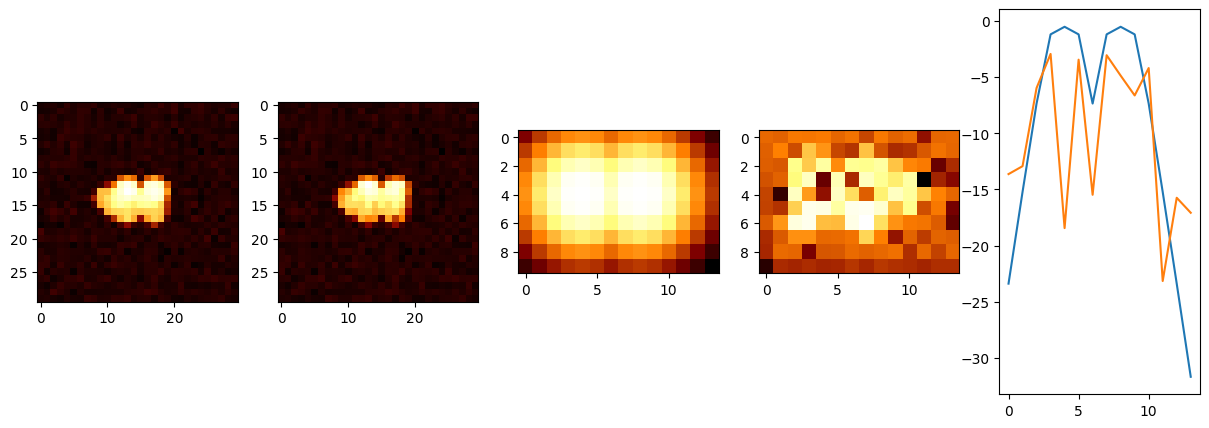

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 5, 1)
import matplotlib.pyplot as plt
plt.imshow(image_tensor.cpu(), cmap='afmhot')

plt.subplot(1, 5, 2)
plt.imshow(idilation(ierosion(image_tensor, tip_tensor), tip_tensor).cpu().detach().numpy(), cmap='afmhot')

plt.subplot(1, 5, 3)
plt.imshow(tip, cmap='afmhot')

plt.subplot(1, 5, 4)
plt.imshow(tip_estimate, cmap='afmhot')

plt.subplot(1, 5, 5)
plt.plot(tip[3, :])
plt.plot(tip_estimate[3, :])

# DataLoader

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import copy

lambda_my = 0.00001
lr_my = 1.0
nepoch = 100

class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx, :, :]
        image = torch.from_numpy(image).float()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        image = image.to(device)
        return image

# Datasetオブジェクトを作成
image_dataset = ImageDataset(images_clean[:30, :, :])

# DataLoaderを作成
data_loader = DataLoader(image_dataset, batch_size=1, shuffle=False)

#
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor = torch.tensor(images_clean[0, :, :], dtype=torch.float32)
image_tensor = image_tensor.to(device)

# Initialize tip with random values
tip_size = tip.shape
tip_tensor = torch.zeros(tip_size, dtype=torch.float64, requires_grad=True, device=device)

# Optimization settings
optimizer = optim.AdamW([tip_tensor], lr=lr_my, weight_decay=lambda_my)

loss_train = []
for epoch in range(nepoch):
    loss_tmp = 0.0
    for x in data_loader:
        optimizer.zero_grad()
        image_reconstructed = idilation(ierosion(x[0, :, :], tip_tensor), tip_tensor)
        loss = torch.mean((image_reconstructed - x[0, :, :])**2)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            tip_tensor.data = torch.clamp(tip_tensor, max=0.0)
            tip_tensor.data = translate_tip_mean(tip_tensor)
        image_reconstructed = idilation(ierosion(x[0, :, :], tip_tensor), tip_tensor)
        loss = torch.mean((image_reconstructed - x[0, :, :])**2)
        loss_tmp += loss.item()
    if iteration % 1 == 0:
        print(f"Epoch: {epoch}, Loss: {loss_tmp}")
    loss_train.append(loss_tmp)

tip_estimate = tip_tensor.detach().to('cpu').numpy()

Epoch: 0, Loss: 9040.456146240234
Epoch: 1, Loss: 8598.335479736328
Epoch: 2, Loss: 8168.422103881836
Epoch: 3, Loss: 7218.467872619629
Epoch: 4, Loss: 6334.740272521973
Epoch: 5, Loss: 5811.011974334717
Epoch: 6, Loss: 5354.81844329834
Epoch: 7, Loss: 4822.349075317383
Epoch: 8, Loss: 4388.277530670166
Epoch: 9, Loss: 4007.334342956543
Epoch: 10, Loss: 3707.2973251342773
Epoch: 11, Loss: 3460.885904312134
Epoch: 12, Loss: 3186.234899520874
Epoch: 13, Loss: 2961.7003688812256
Epoch: 14, Loss: 2739.6436080932617
Epoch: 15, Loss: 2514.903666496277
Epoch: 16, Loss: 2330.784945487976
Epoch: 17, Loss: 2118.3162899017334
Epoch: 18, Loss: 1947.2652597427368
Epoch: 19, Loss: 1804.7866735458374
Epoch: 20, Loss: 1674.0023937225342
Epoch: 21, Loss: 1590.1977863311768
Epoch: 22, Loss: 1484.8169918060303
Epoch: 23, Loss: 1390.7377362251282
Epoch: 24, Loss: 1276.863787651062
Epoch: 25, Loss: 1163.7131977081299
Epoch: 26, Loss: 1060.2095551490784
Epoch: 27, Loss: 956.7555243968964
Epoch: 28, Loss: 85

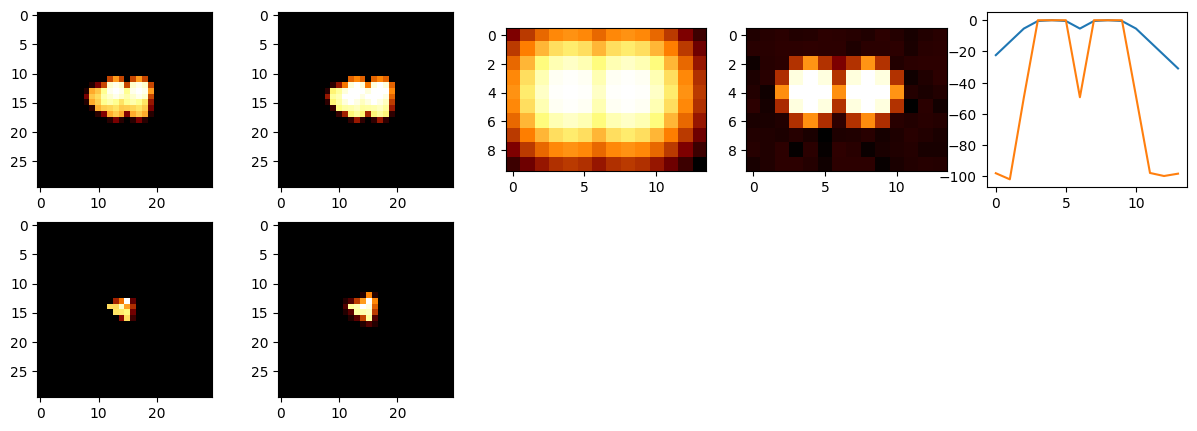

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(2, 5, 1)
plt.imshow(image_tensor.cpu(), cmap='afmhot')

plt.subplot(2, 5, 2)
plt.imshow(idilation(ierosion(image_tensor, tip_tensor), tip_tensor).cpu().detach().numpy(), cmap='afmhot')

plt.subplot(2, 5, 3)
plt.imshow(tip, cmap='afmhot')

plt.subplot(2, 5, 4)
plt.imshow(tip_estimate, cmap='afmhot')

plt.subplot(2, 5, 5)
plt.plot(tip[4, :])
plt.plot(tip_estimate[4, :])

plt.subplot(2, 5, 6)
plt.imshow(surface_tensor.cpu(), cmap='afmhot')

plt.subplot(2, 5, 7)
plt.imshow(ierosion(image_tensor, tip_tensor).cpu().detach().numpy(), cmap='afmhot')

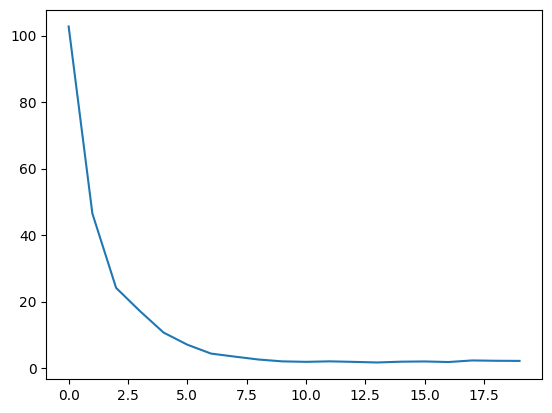

In [ ]:
plt.plot(loss_train)

# Working in progress...

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torch.optim import AdamW
import copy

lambda_my = 0.00001
lr_my = 1.0
nepoch = 10

class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx, :, :]
        image = torch.from_numpy(image).float()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        image = image.to(device)
        return image

# Datasetオブジェクトを作成
image_dataset = ImageDataset(images[:30, :, :])

# DataLoaderを作成
data_loader = DataLoader(image_dataset, batch_size=1, shuffle=False)

# CustomModelを作成
class CustomModel(torch.nn.Module):
    def __init__(self, tip):
        super(CustomModel, self).__init__()
        nx, ny = tip.shape
        initial_tip = torch.zeros((nx, ny), dtype=torch.float32)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        initial_tip = initial_tip.to(device)
        self.P = torch.nn.Parameter(initial_tip)

    def forward(self, x):
        return idilation(ierosion(x, self.P), self.P)

m = CustomModel(tip)

def loss_fn(image):
    return torch.nn.functional.mse_loss(m.forward(image), image, reduction='mean')

optimizer = AdamW(m.parameters(), lr=lr_my, weight_decay=lambda_my)

In [ ]:
loss_train = []
for epoch in range(nepoch):
    loss_tmp = 0.0
    for x in data_loader:
        optimizer.zero_grad()
        loss = loss_fn(x[0])
        loss.backward()
        optimizer.step()
        #with torch.no_grad():
            #m.P.data = torch.clamp(m.P, max=0.0)
            #m.P.data = translate_tip_mean(m.P)
        loss_tmp += loss_fn(x[0]).item()

    print(epoch, loss_tmp)
    loss_train.append(loss_tmp)

tip_estimate = m.P.detach().to('cpu').numpy()

0 95.3866126537323
1 95.3866126537323
2 95.3866126537323
3 95.3866126537323
4 95.3866126537323
5 95.3866126537323
6 95.3866126537323
7 95.3866126537323
8 95.3866126537323
9 95.3866126537323


tensor(12.1353, device='cuda:0', grad_fn=<MaxBackward1>)


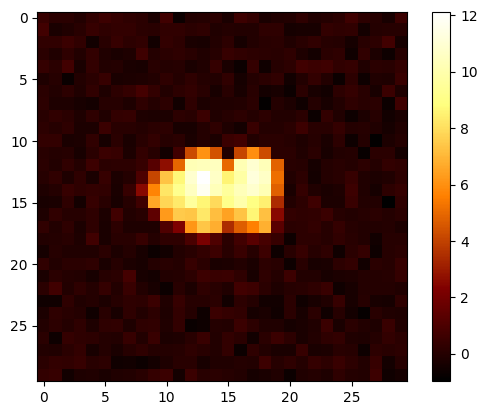

In [ ]:
image_reconstructed = idilation(ierosion(image_tensor, tip_tensor), tip_tensor)
plt.imshow(image_reconstructed.detach().cpu(), cmap='afmhot')
plt.colorbar()
print(torch.max(image_reconstructed))

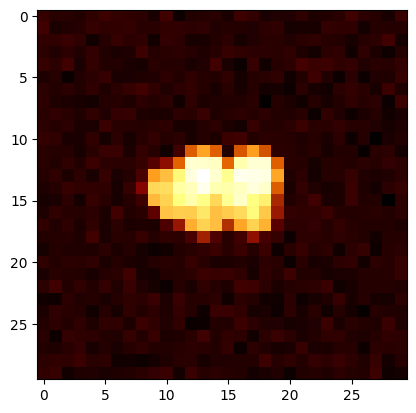

In [ ]:
plt.imshow(image_tensor.cpu(), cmap='afmhot')

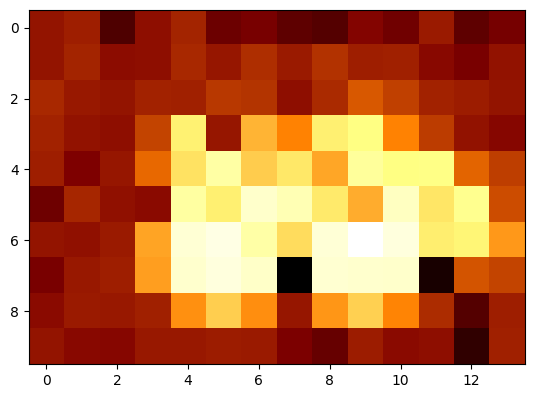

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(tip_estimate, cmap='afmhot')

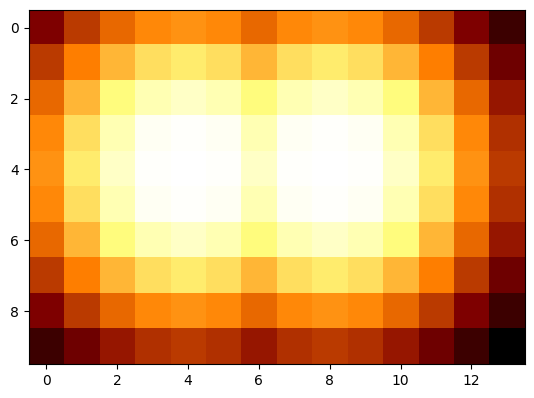

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(tip, cmap='afmhot')

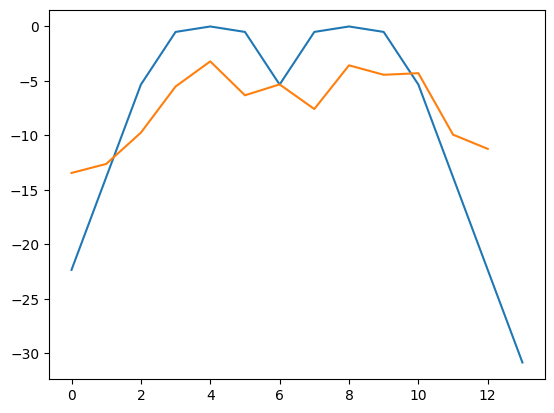

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.plot(tip[4, :])
plt.plot(tip_estimate[4, 1:])